# 1.0 Import

In [8]:
#Load and edit dataframe
import pyarrow
import numpy as np
import pandas as pd

# Data Visualization
import seaborn           as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Select Train and Test
from sklearn.model_selection import train_test_split

# ML - Algoritms
from sklearn.preprocessing   import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import warnings 
warnings.filterwarnings( 'ignore' ) 

## Load DataSet

In [11]:
df = pd.read_csv('../dataset/all_bovespa.parquet')

In [12]:
df_petro = df.copy()

# Data Analysis


In [13]:
print(f'nº of columns: {df_petro.shape[0]}, nº of rows:{df_petro.shape[1]}')

nº of columns: 1001978, nº of rows:9


In [14]:
df_petro.dtypes

data_pregao          object
sigla_acao           object
nome_acao            object
preco_abertura      float64
preco_maximo        float64
preco_minimo        float64
preco_fechamento    float64
qtd_negocios          int64
volume_negocios       int64
dtype: object

In [15]:
a = df_petro[df_petro['nome_acao']=='PETROBRAS']
a

,data_pregao,sigla_acao,nome_acao,preco_abertura,preco_maximo,preco_minimo,preco_fechamento,qtd_negocios,volume_negocios
218,2012-01-02,PETR3,PETROBRAS,23.13,23.61,22.74,23.21,3781500,0
219,2012-01-02,PETR4,PETROBRAS,21.51,22.12,21.26,21.73,20482400,4
550,2012-01-03,PETR3,PETROBRAS,23.21,24.02,23.21,24.02,5408100,1
551,2012-01-03,PETR4,PETROBRAS,21.83,22.41,21.81,22.41,23089200,5
884,2012-01-04,PETR3,PETROBRAS,23.80,24.28,23.57,24.17,4671600,1
...,...,...,...,...,...,...,...,...,...
1001226,2023-05-15,PETR4,PETROBRAS,26.06,26.15,25.40,25.66,81996700,21
1001522,2023-05-16,PETR3,PETROBRAS,28.56,29.99,28.56,29.20,31615500,9
1001523,2023-05-16,PETR4,PETROBRAS,26.11,27.03,26.08,26.30,117782700,31
1001865,2023-05-17,PETR3,PETROBRAS,29.53,29.64,28.81,29.02,24810700,7


# Data transformation

In [16]:
df_petro['data_pregao'] = pd.to_datetime(df_petro['data_pregao'], format='%Y-%m-%d')

In [17]:
df_petro.dtypes

data_pregao         datetime64[ns]
sigla_acao                  object
nome_acao                   object
preco_abertura             float64
preco_maximo               float64
preco_minimo               float64
preco_fechamento           float64
qtd_negocios                 int64
volume_negocios              int64
dtype: object

# Select only one share to predict

In [18]:
# Filter share_data
df_petro = df[df['sigla_acao']=='PETR4']
print(f'nº of rows: {df_petro.shape[0]}, nº of columns:{df_petro.shape[1]}')

nº of rows: 2565, nº of columns:9


In [19]:
df_petro_cls = df_petro[['data_pregao', 'preco_fechamento']]
df_petro_cls.tail()

,data_pregao,preco_fechamento
1000547,2023-05-11,25.43
1000612,2023-05-12,26.25
1001226,2023-05-15,25.66
1001523,2023-05-16,26.30
1001866,2023-05-17,25.66


In [20]:
# set to index with date
df_petro_cls = df_petro_cls.set_index(pd.DatetimeIndex(df_petro_cls['data_pregao'].values))

In [21]:
df_petro_cls.tail()

,data_pregao,preco_fechamento
2023-05-11,2023-05-11,25.43
2023-05-12,2023-05-12,26.25
2023-05-15,2023-05-15,25.66
2023-05-16,2023-05-16,26.30
2023-05-17,2023-05-17,25.66


In [22]:
# drop column 'data_pregao'
df_petro_cls.drop(['data_pregao'], axis=1, inplace=True)

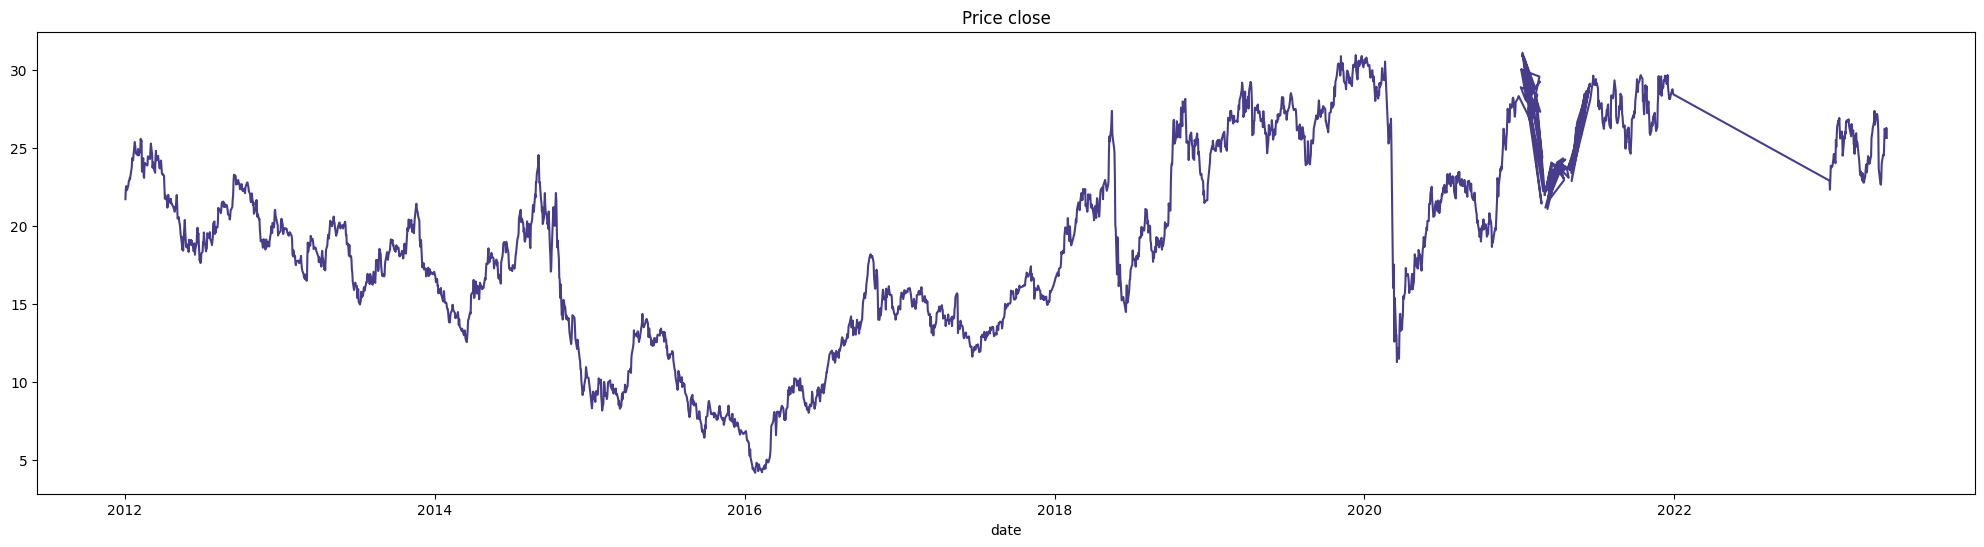

In [25]:
# Plot the dataframe
plt.figure(figsize=(25,6))
plt.title('Price close')
plt.plot(df_petro_cls['preco_fechamento'], color='darkslateblue' )
plt.xlabel('date');


# Data Train and Test

In [26]:
# Data analysis
qtt_rows = len(df_petro_cls)

r_train = round(.70*qtt_rows)

r_test = qtt_rows - r_train

info = (
    f'Train = 0:{r_train} | '
    f'Test = {r_train}:{r_train + r_test}'
    )
info

'Train = 0:1795 | Test = 1795:2565'

# Normalize and Reescale 

In [27]:
# Normalizing
std = StandardScaler()
df_scaled = std.fit_transform(df_petro_cls)

# Separating into Train and Test

In [29]:
train = df_scaled[:r_train]

test = df_scaled[r_train: r_train+r_test]

print(len(train), len(test))

1795 770


In [30]:
# Convert an array of values into a df matrix

def create_df(df, steps=1):
    dataX, dataY = [], []
    for i in range(len(df)-steps-1):
        a = df[i:(i+steps), 0]
        dataX.append(a)
        dataY.append(df[i+steps,0])
    return np.array(dataX), np.array(dataY)

# dexa os valores formatados no padrão que o LSTM espera para aprender

In [31]:
# gerando os dados de treino e teste

steps = 15
X_train, Y_train = create_df(train, steps)
X_test, Y_test = create_df(test, steps)

In [32]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)


(1779, 15)
(1779,)
(754, 15)
(754,)


In [33]:
# Gerando os dados no formato que o modelo espera
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_train.shape[0] → 1714 linhas de treino | X_train.shape[1] → 15 dias de treino
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Model Apply

In [34]:
# Camadas da Rede Neural
model = Sequential()
model.add(LSTM(35, return_sequences=True, input_shape=(steps,1))) #1ª camada
#LSTM(35) → qtt de neuronios usados | input_shape=(steps,1) → qtt de dias a ser previsto e retornado
model.add(LSTM(35, return_sequences=True)) #2ª camada
model.add(LSTM(35)) #3ª camada
model.add(Dropout(0.2)) 
#Dropout evita o overfit do treinamento
model.add(Dense(1)) #retonrnando um unico resultado


2023-05-18 15:57:23.454758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-18 15:57:23.459227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-18 15:57:23.461195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [35]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 35)            5180      
                                                                 
 lstm_1 (LSTM)               (None, 15, 35)            9940      
                                                                 
 lstm_2 (LSTM)               (None, 35)                9940      
                                                                 
 dropout (Dropout)           (None, 35)                0         
                                                                 
 dense (Dense)               (None, 1)                 36        
                                                                 
Total params: 25,096
Trainable params: 25,096
Non-trainable params: 0
_________________________________________________________________


In [36]:
# treinamento do modelo
validation = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=15, verbose=2)

Epoch 1/100


2023-05-18 15:57:37.349246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-18 15:57:37.351344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-18 15:57:37.355041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-05-18 15:57:46.396393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-18 15:57:46.398208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-18 15:57:46.400165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

119/119 - 10s - loss: 0.1071 - val_loss: 0.0965 - 10s/epoch - 84ms/step
Epoch 2/100
119/119 - 2s - loss: 0.0445 - val_loss: 0.0824 - 2s/epoch - 17ms/step
Epoch 3/100
119/119 - 2s - loss: 0.0371 - val_loss: 0.0618 - 2s/epoch - 15ms/step
Epoch 4/100
119/119 - 2s - loss: 0.0360 - val_loss: 0.0527 - 2s/epoch - 15ms/step
Epoch 5/100
119/119 - 2s - loss: 0.0283 - val_loss: 0.0543 - 2s/epoch - 15ms/step
Epoch 6/100
119/119 - 2s - loss: 0.0297 - val_loss: 0.0491 - 2s/epoch - 17ms/step
Epoch 7/100
119/119 - 2s - loss: 0.0270 - val_loss: 0.0436 - 2s/epoch - 16ms/step
Epoch 8/100
119/119 - 2s - loss: 0.0225 - val_loss: 0.0406 - 2s/epoch - 15ms/step
Epoch 9/100
119/119 - 2s - loss: 0.0208 - val_loss: 0.0487 - 2s/epoch - 15ms/step
Epoch 10/100
119/119 - 2s - loss: 0.0185 - val_loss: 0.0392 - 2s/epoch - 15ms/step
Epoch 11/100
119/119 - 2s - loss: 0.0199 - val_loss: 0.0362 - 2s/epoch - 15ms/step
Epoch 12/100
119/119 - 2s - loss: 0.0182 - val_loss: 0.0376 - 2s/epoch - 16ms/step
Epoch 13/100
119/119 - 

Epoch 100/100
119/119 - 2s - loss: 0.0110 - val_loss: 0.0406 - 2s/epoch - 17ms/step


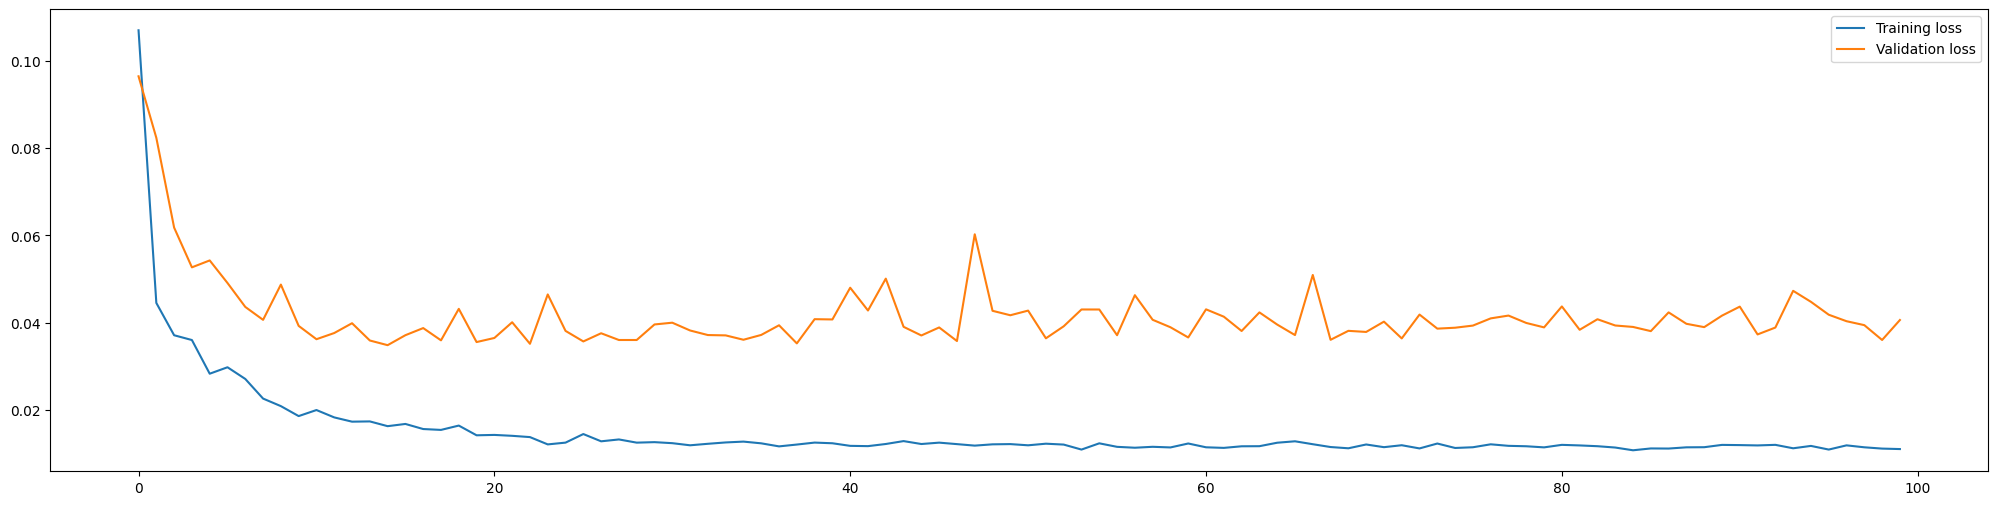

In [38]:
plt.figure(figsize=(25,6))
plt.plot(validation.history['loss'], label='Training loss')
plt.plot(validation.history['val_loss'], label='Validation loss')
plt.legend();

In [39]:
# Prediction
prev = model.predict(X_test)
prev = std.inverse_transform(prev)
prev

2023-05-18 16:03:14.157451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-18 16:03:14.159252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-18 16:03:14.161400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24/24 [==============================] - 2s 11ms/step


array([[26.433653 ],
       [26.51642  ],
       [26.426266 ],
       [26.082647 ],
       [27.036127 ],
       [26.445534 ],
       [26.510828 ],
       [25.623327 ],
       [25.763136 ],
       [25.542639 ],
       [25.03624  ],
       [24.472733 ],
       [25.207565 ],
       [26.102922 ],
       [26.038961 ],
       [25.70762  ],
       [25.890984 ],
       [25.949043 ],
       [26.511517 ],
       [26.173512 ],
       [25.925085 ],
       [25.27201  ],
       [25.687475 ],
       [25.820223 ],
       [25.594517 ],
       [26.02516  ],
       [26.433859 ],
       [26.375498 ],
       [26.906242 ],
       [26.51436  ],
       [26.927752 ],
       [26.685102 ],
       [26.815758 ],
       [27.080431 ],
       [27.150702 ],
       [27.899824 ],
       [27.802631 ],
       [27.214947 ],
       [27.360495 ],
       [26.8155   ],
       [27.076437 ],
       [26.85635  ],
       [26.532845 ],
       [26.814459 ],
       [27.02035  ],
       [27.09533  ],
       [27.355806 ],
       [27.72

In [40]:
# Predict the next 15 days
lenght_test = len(test)
lenght_test

770

In [41]:
# Get the last days to step
days_input_steps =lenght_test - steps
days_input_steps

755

In [42]:
# Transform in array
input_steps = test[days_input_steps:]
input_steps = np.array(input_steps).reshape(1, -1)
input_steps

array([[1.20329944, 1.10095509, 0.72306827, 0.57191354, 0.55931731,
        0.61600034, 0.77030412, 0.85060507, 0.8632013 , 0.85375413,
        0.99546169, 1.12457302, 1.03167584, 1.13244566, 1.03167584]])

In [43]:
# Return in list
list_output_steps = list(input_steps)
list_output_steps = list_output_steps[0].tolist()
list_output_steps

[1.203299442323649,
 1.1009550939503276,
 0.7230682691872935,
 0.5719135392820798,
 0.559317311789979,
 0.6160003355044339,
 0.7703041222826728,
 0.8506050725448178,
 0.8632013000369185,
 0.8537541294178429,
 0.9954616887039804,
 1.1245730204980169,
 1.031675842743771,
 1.1324456626805803,
 1.031675842743771]

In [44]:
#Loop to preview the next 10 days
pred_output = [] #→ recebe os dias a serem previstos
i = 0
n_future = 10
while(i<n_future):
    if(len(list_output_steps) > steps):
       input_steps = np.array(list_output_steps[1:])
       print('Day {}. Value Entrance → {}'.format(i, input_steps))
       input_steps = input_steps.reshape(1, -1)
       input_steps = input_steps.reshape((1, steps, 1))
       #print(input_steps)
       pred = model.predict(input_steps, verbose=0)
       print('Day {}. Value Predict → {}'.format(i, pred))
       list_output_steps.extend(pred[0].tolist())
       list_output_steps = list_output_steps[1:]
       #print(list_output_steps)
       pred_output.extend(pred.tolist())
       i = i+1
       
    else:
       input_steps = input_steps.reshape((1, steps, 1))
       pred= model.predict(input_steps, verbose=0)
       print(pred[0])
       list_output_steps.extend(pred[0].tolist())
       print(len(list_output_steps))
       pred_output.extend(pred.tolist())
       i = i+1
       
print(pred_output)
       
       

[0.9693974]
16
Day 1. Value Entrance → [1.10095509 0.72306827 0.57191354 0.55931731 0.61600034 0.77030412
 0.85060507 0.8632013  0.85375413 0.99546169 1.12457302 1.03167584
 1.13244566 1.03167584 0.96939743]
Day 1. Value Predict → [[0.9334588]]
Day 2. Value Entrance → [0.72306827 0.57191354 0.55931731 0.61600034 0.77030412 0.85060507
 0.8632013  0.85375413 0.99546169 1.12457302 1.03167584 1.13244566
 1.03167584 0.96939743 0.93345881]
Day 2. Value Predict → [[0.87979496]]
Day 3. Value Entrance → [0.57191354 0.55931731 0.61600034 0.77030412 0.85060507 0.8632013
 0.85375413 0.99546169 1.12457302 1.03167584 1.13244566 1.03167584
 0.96939743 0.93345881 0.87979496]
Day 3. Value Predict → [[0.8307607]]
Day 4. Value Entrance → [0.55931731 0.61600034 0.77030412 0.85060507 0.8632013  0.85375413
 0.99546169 1.12457302 1.03167584 1.13244566 1.03167584 0.96939743
 0.93345881 0.87979496 0.83076072]
Day 4. Value Predict → [[0.785499]]
Day 5. Value Entrance → [0.61600034 0.77030412 0.85060507 0.863201

In [45]:
# transform exit
prev = std.inverse_transform(pred_output)
prev = np.array(prev).reshape(1, -1)
list_output_prev = list(prev)
list_output_prev = prev[0].tolist()
list_output_prev

[25.264463052886114,
 25.03621299570124,
 24.69538809482181,
 24.38396635911637,
 24.09650416005468,
 23.834216660890004,
 23.598347795095957,
 23.3858282344303,
 23.193373631109406,
 23.017421777590187]

In [46]:
# format exit (date to predict)
dates = pd.to_datetime(df_petro['data_pregao'])
predict_dates = pd.date_range(list(dates)[-1] + pd.DateOffset(1), periods=10, freq='b').to_list()
predict_dates

[Timestamp('2023-05-18 00:00:00'),
 Timestamp('2023-05-19 00:00:00'),
 Timestamp('2023-05-22 00:00:00'),
 Timestamp('2023-05-23 00:00:00'),
 Timestamp('2023-05-24 00:00:00'),
 Timestamp('2023-05-25 00:00:00'),
 Timestamp('2023-05-26 00:00:00'),
 Timestamp('2023-05-29 00:00:00'),
 Timestamp('2023-05-30 00:00:00'),
 Timestamp('2023-05-31 00:00:00')]

In [47]:
# New DataFrame 
forecast_dates = []
for i in predict_dates:
    forecast_dates.append(i.date())
    
df_forecast = pd.DataFrame({'data_pregao':np.array(forecast_dates), 'preco_fechamento':list_output_prev})
df_forecast['data_pregao'] = pd.to_datetime(df_forecast['data_pregao'])

In [48]:
df_forecast = df_forecast.set_index(pd.DatetimeIndex(df_forecast['data_pregao'].values))
df_forecast.drop('data_pregao', axis=1, inplace=True)
df_forecast

,preco_fechamento
2023-05-18,25.264463
2023-05-19,25.036213
2023-05-22,24.695388
2023-05-23,24.383966
2023-05-24,24.096504
2023-05-25,23.834217
2023-05-26,23.598348
2023-05-29,23.385828
2023-05-30,23.193374
2023-05-31,23.017422


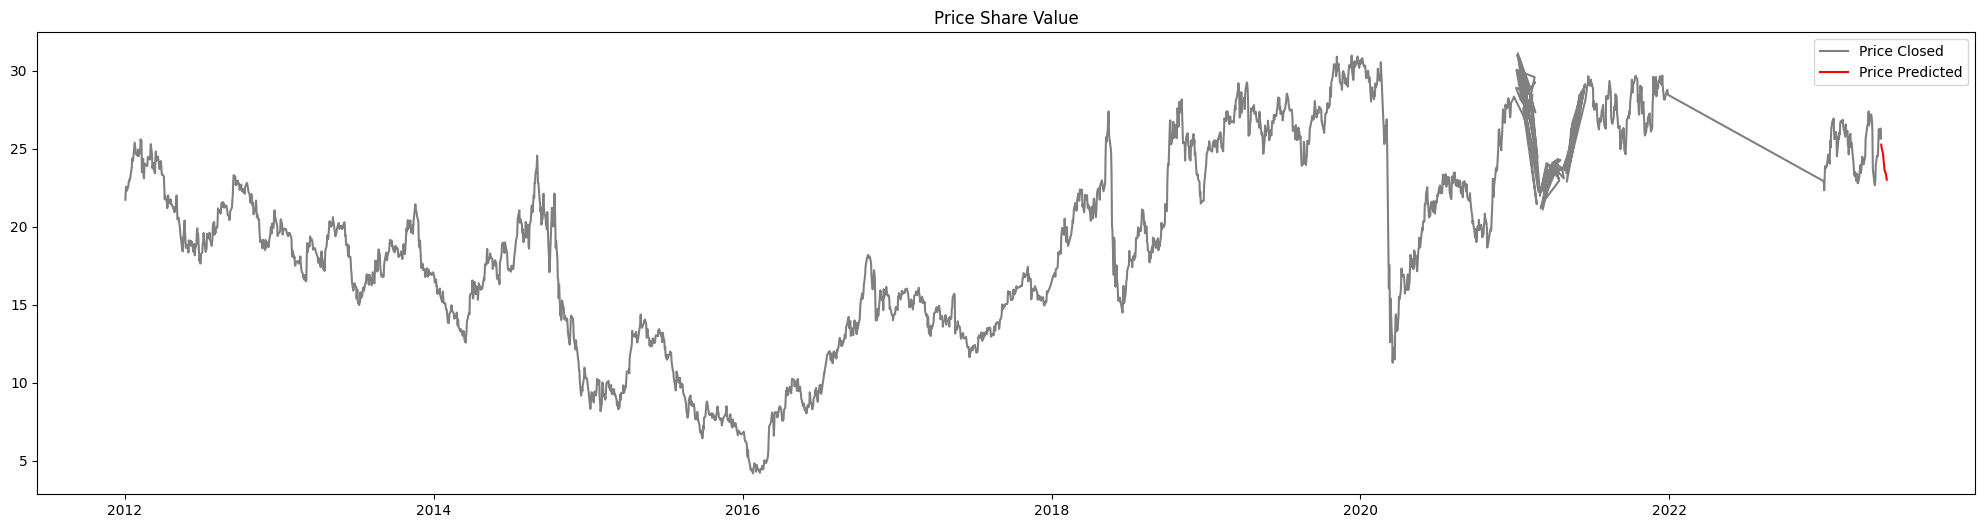

In [62]:
plt.figure(figsize=(25,6))
plt.title('Price Share Value')
plt.plot(df_petro_cls['preco_fechamento'], color='gray')
plt.plot(df_forecast['preco_fechamento'], color='red')
plt.legend(['Price Closed', 'Price Predicted'])
plt.show();


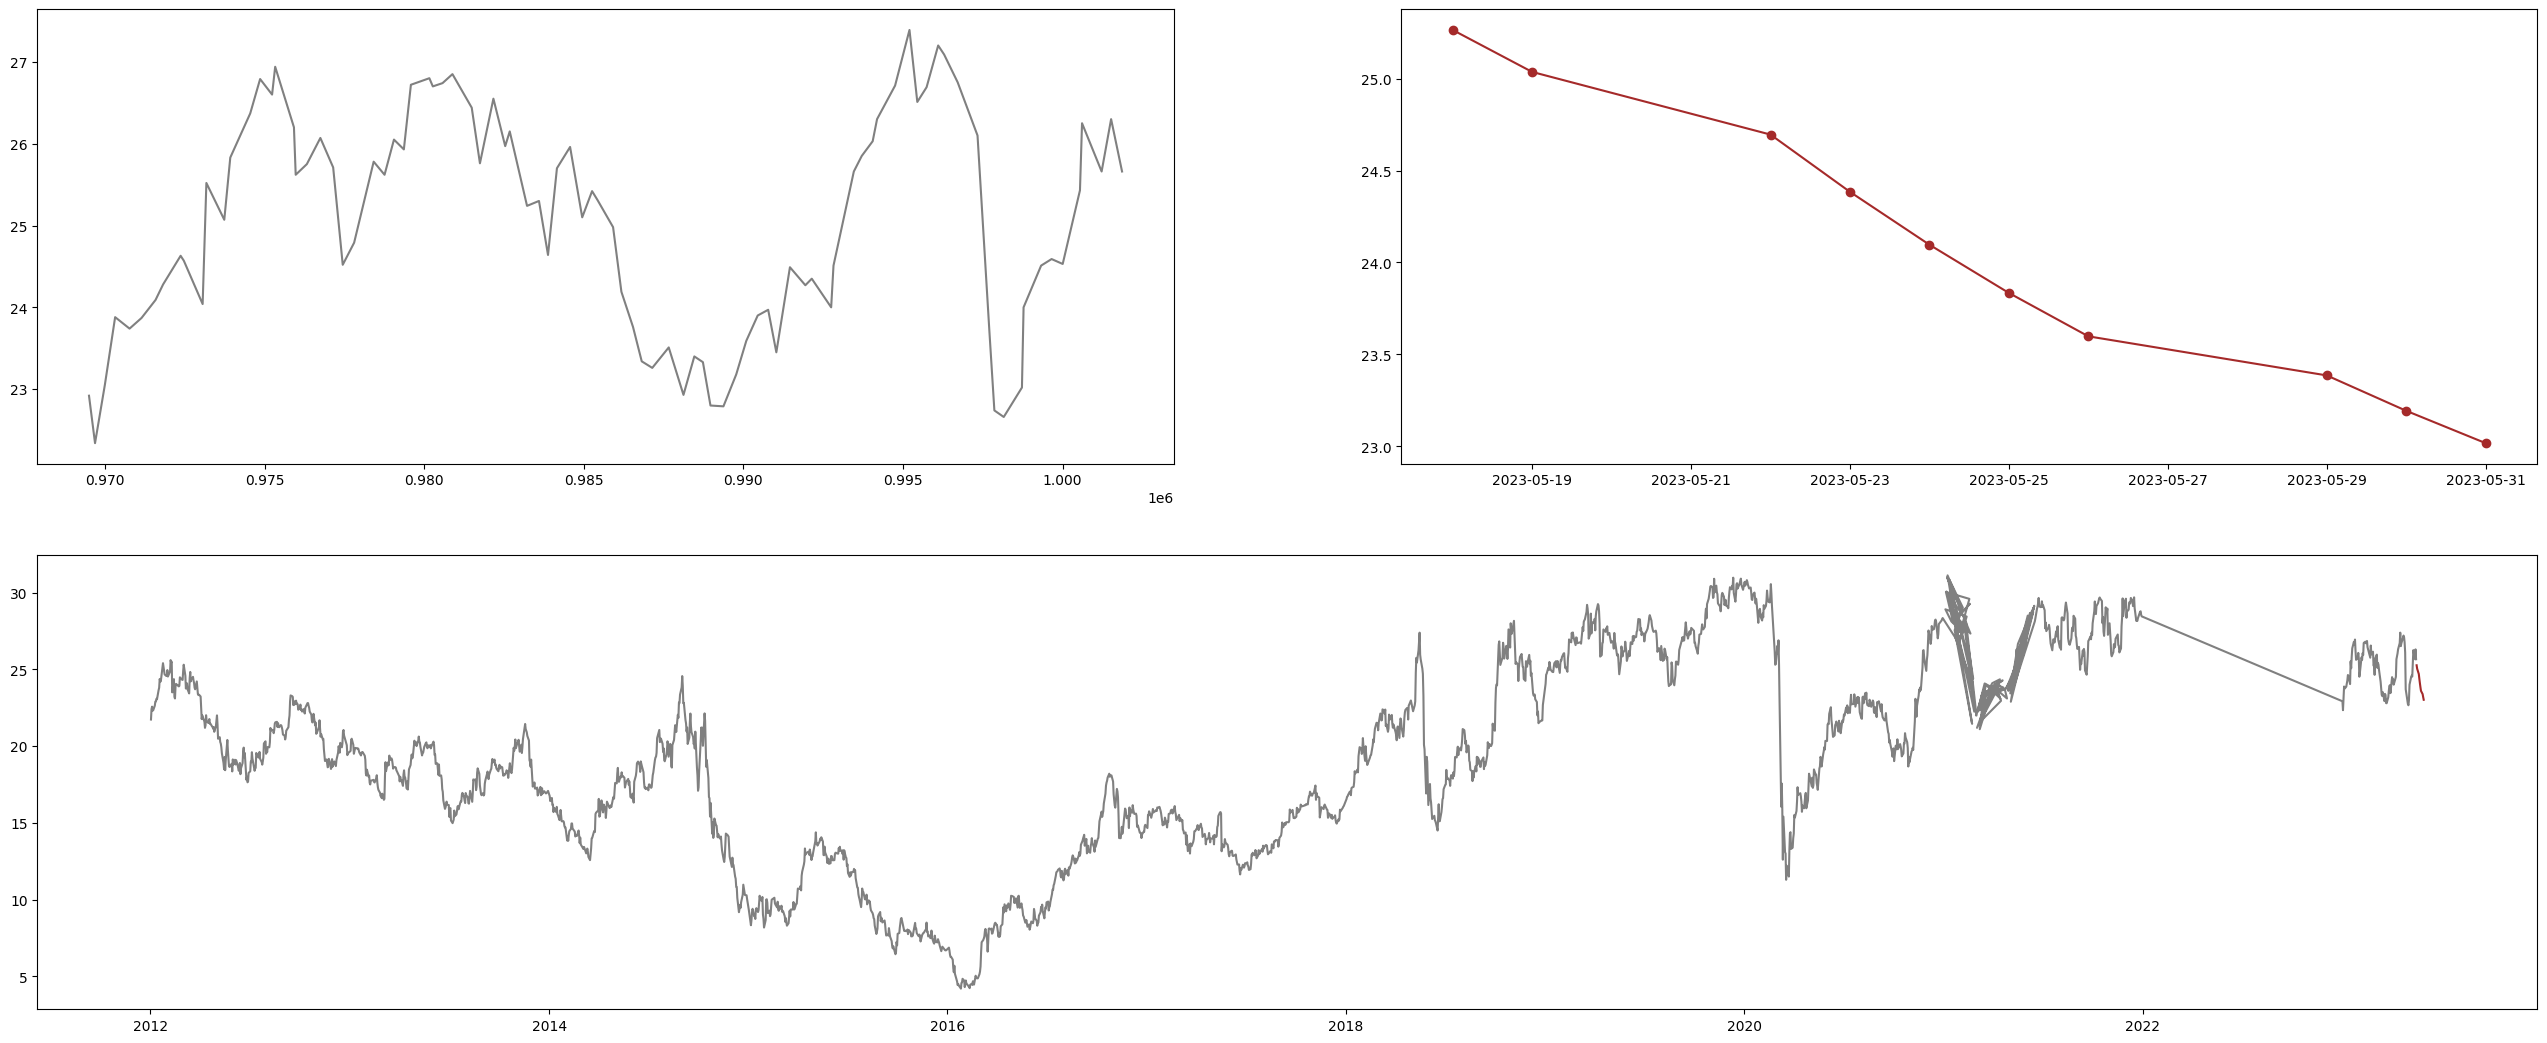

In [70]:
b = df_petro[df_petro['data_pregao'] > '2023-01-01']
fig = plt.figure(figsize=(25,10))
plt.subplots_adjust(bottom = 0., left = 0, top = 1., right = 1)

# Create first axes, the top-left plot with green plot
sub1 = fig.add_subplot(2,2,1) # two rows, two columns, fist cell
plt.plot(b['preco_fechamento'], color='gray')
# Create second axes, the top-left plot with orange plot
sub2 = fig.add_subplot(2,2,2) # two rows, two columns, second cell
plt.plot(df_forecast['preco_fechamento'], label='Predict Value', color='brown', marker='o');

# Create third axes, a combination of third and fourth cell
sub3 = fig.add_subplot(2,2,(3,4)) # two rows, two colums, combined third and fourth cell
plt.plot(df_petro_cls['preco_fechamento'],color='gray')
plt.plot(df_forecast['preco_fechamento'], color='brown');

Finish